# 07 PyTorch Experiment Tracking

Machine learning is very experimental.

In order to figure out which experiments are worth pursuing, that's where **experiment tracking** comes in, it helps you to figure what doesn't work so you can figure out what does work!

## 0. Getting setup

In [1]:
import torch
import torchvision

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3435, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 3435 (delta 55), reused 97 (delta 41), pack-reused 3302
Receiving objects: 100% (3435/3435), 643.58 MiB | 17.64 MiB/s, done.
Resolving deltas: 100% (1962/1962), done.
Updating files: 100% (222/222), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

## 1. Get data

Want to get pizza, steak, sushi images.

So we can run experiments building **FoodVision Mini** and see which model performs best.

In [5]:
import os
import zipfile
from pathlib import Path
import requests

def download_data(
    source: str,
    destination: str,
    remove_source: bool = True
) -> Path:
  """
  Downloads a zipped dataset from source and unzips to destination.
  """
  # Setup path to data folder
  data_path = Path("data/")
  image_path = data_path / destination

  # If the image folder doesn't exist
  if image_path.is_dir():
    print(f"[INFO] {image_path} directory already exists, skipping download...")
  else:
    print(f"[INFO] Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download the target data
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
      response = requests.get(source)
      print(f"[INFO] Downloading {target_file} from {source}...")
      f.write(response.content)

    # Unzip target file
    with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
      print(f"[INFO] Unzipping {target_file} data...")
      zip_ref.extractall(image_path)

    # Remove .zip file if needed
    if remove_source:
      os.remove(data_path / target_file)

  return image_path

In [6]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                            destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

### 2.1 Create DataLoaders with manual transforms

The goal with transforms is to ensure your custom data is formatted in a reproducible way as well as a way that will suit pretrained models.

In [7]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [8]:
# Setup ImageNet normalization layers
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, .224, 0.225])

# Create transform pipeline manually
from torchvision import transforms
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f"Manually created transforms: {manual_transforms}")

# Create DataLoaders
from going_modular.going_modular import data_setup

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7f8b7f24ca90>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

The same principle applies for automatic transforms: we want our custom data in the same format as a pretrained model was trained on.

In [9]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights
# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7f8b7f24cd60>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freeze the base layers and change the classifier head

In [10]:
# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
# Freeze all base layers by setting their requires_grad attribute to False
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False

In [12]:
# Change classifier head
set_seeds()

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)

In [13]:
from torchinfo import summary

summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train a single model and track results

In [14]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

In [15]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [16]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from going_modular.going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
    # Close the writer
    writer.close()
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

In [17]:
# Train model
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

results

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8966 | train_acc: 0.6562 | test_loss: 0.7839 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.8045 | train_acc: 0.7422 | test_loss: 0.6716 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6787 | train_acc: 0.7305 | test_loss: 0.6697 | test_acc: 0.8258
Epoch: 5 | train_loss: 0.7066 | train_acc: 0.7188 | test_loss: 0.6737 | test_acc: 0.7737


{'train_loss': [1.0929433926939964,
  0.896570198237896,
  0.8045311570167542,
  0.67867611348629,
  0.7066122516989708],
 'train_acc': [0.40234375, 0.65625, 0.7421875, 0.73046875, 0.71875],
 'test_loss': [0.9124558369318644,
  0.7839208841323853,
  0.6715965072313944,
  0.6696674227714539,
  0.6737417777379354],
 'test_acc': [0.5501893939393939,
  0.8560606060606061,
  0.8863636363636364,
  0.8257575757575758,
  0.7736742424242425]}

## 5. View our model's results in TensorBoard

In [19]:
# %load_ext tensorboard
# %tensorboard --logdir runs

## 6. Create a `SummaryWriter()` function

By default out `SummaryWriter()` class saves to `log_dir` parameter.

How about if we wanted to save different experiments to different folders.

In essence, one experiment = one folder

We'd like to track:
- Experiment date/timestamp
- Experiment name
- Model name
- Extra - is there anything else to be tracked?

In [20]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
  """Creates a SummaryWriter instance"""
  from datetime import datetime
  import os

  # Get a timestamp of current date in reverse order
  timestamp = datetime.now().strftime("%Y-%m-%d")

  if extra:
    # Create log directory path
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
  else:
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
  print(f"[INFO] Created SummaryWriter saving to {log_dir}")
  return SummaryWriter(log_dir=log_dir)

In [21]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")
example_writer

[INFO] Created SummaryWriter saving to runs/2023-02-21/data_10_percent/effnetb0/5_epochs


### 6.1 Update our train function to be able to use the write function

In [22]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from going_modular.going_modular.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        if writer:
          writer.add_scalars(main_tag="Loss",
                            tag_scalar_dict={"train_loss": train_loss,
                                              "test_loss": test_loss},
                            global_step=epoch)
          writer.add_scalars(main_tag="Accuracy",
                            tag_scalar_dict={"train_acc": train_acc,
                                              "test_acc": test_acc},
                            global_step=epoch)
          writer.add_graph(model=model,
                          input_to_model=torch.randn(32, 3, 224, 224).to(device))
          
          # Close the writer
          writer.close()
        ### End new ###

    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments



### 7.1 What kind of experiments should you run?

The number of machine learning experiments you can run, is like the number of different models you can build... almost limitless.

However, you can't test everything...

So what should you test?
- Change the number of epochs
- Change the number of hidden layers/units
- Change the amount of data (right now we're using 10% of the Food101 dataset for pizza, steak, sushi).
- Change the learning rate
- Try different kinds of data augmentation
- Choose a different architecture

### 7.2 What experiments are we going to run?

We're going to turn three dials:
- Model size - EffNetB0 vs EffNetB2
- Dataset size - 10% and 20%
- Training time - 5 epochs vs 10 epochs

**Goal** - A model that is well performing but sill small enough to run a mobile device or a web browser.

| Experiment number |	Training Dataset |	Model (pretrained on ImageNet) |	Number of epochs |
| --- | --- | --- | --- |
| 1 | Pizza, Steak, Sushi 10% percent |	EfficientNetB0 |	5
| 2 | Pizza, Steak, Sushi 10% percent |	EfficientNetB2 |	5
| 3 | Pizza, Steak, Sushi 10% percent |	EfficientNetB0 |	10
| 4 | Pizza, Steak, Sushi 10% percent |	EfficientNetB2 |	10
| 5 | Pizza, Steak, Sushi 20% percent |	EfficientNetB0 |	5
| 6 | Pizza, Steak, Sushi 20% percent |	EfficientNetB2 |	5
| 7 | Pizza, Steak, Sushi 20% percent |	EfficientNetB0 |	10
| 8 | Pizza, Steak, Sushi 20% percent |	EfficientNetB2 |	10

### 7.3 Download different datasets

We want two datasets:
1. Pizza steak sushi 10%
1. Pizza steak sushi 20%

In [24]:
# Download 10 percent and 20 percent datasets
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_10_percent_path, data_20_percent_path

[INFO] data/pizza_steak_sushi directory already exists, skipping download...
[INFO] data/pizza_steak_sushi_20_percent directory already exists, skipping download...


(PosixPath('data/pizza_steak_sushi'),
 PosixPath('data/pizza_steak_sushi_20_percent'))

### 7.4 Transform Datasets into DataLoaders

We'll need to transform our data in a few ways:
1. Resize the images to (224, 224)
1. Make sure image tensor values are between [0, 1]
1. Normalize the images so they have same data distribution as ImageNet

In [25]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup test directory path
# Only need one
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [26]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [27]:
BATCH_SIZE = 32

# Creating training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir,
                                                                                          transform=simple_transform,
                                                                                          batch_size=BATCH_SIZE)

print(f"Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20_percent)}")
print(f"Class names: {class_names}")

Number of batches of size 32 in 10% train data: 8
Number of batches of size 32 in 20% train data: 15
Class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

We want two functions:
1. Create a `torchvision.models.efficientnet_b0()` feature extractor with a frozen backbone and a custom classifier head.
1. Create a `torchvision.models.efficientnet_b2()` feature extractor with a frozen backbone and a custom classifier head.

In [28]:
import torchvision

# Create an EffNetB2
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

effnetb2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [29]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
  # Get the weights and setup a model
  weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
  model = torchvision.models.efficientnet_b0(weights=weights).to(device)

  # Freeze the base model layers
  for params in model.parameters():
    params.requeires_grad = False

  # Change the classifier head
  set_seeds()
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1280, out_features=OUT_FEATURES)
  ).to(device)

  # Give the model a name
  model.name = "effnetb0"
  print(f"[INFO]  Created new {model.name} model...")
  return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
  # Get the weights and setup a model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  model = torchvision.models.efficientnet_b2(weights=weights).to(device)

  # Freeze the base model layers
  for params in model.parameters():
    params.requeires_grad = False

  # Change the classifier head
  set_seeds()
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=OUT_FEATURES)
  ).to(device)

  # Give the model a name
  model.name = "effnetb2"
  print(f"[INFO]  Created new {model.name} model...")
  return model

### 7.6 Create experiments and set up training code

In [30]:
# Create epoch list
num_epochs = [5, 10]

# Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# Create a DataLoaders dictionary
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [33]:
%%time
from going_modular.going_modular.utils import save_model

# Set seeds
set_seeds()

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
  # Loop through the epochs
  for epochs in num_epochs:
    # Loop through each model name and create a new model instance
    for model_name in models:

      # Print out info
      experiment_number +=1
      print(f"[INFO] Experiment number: {experiment_number}")
      print(f"[INFO] Model: {model_name}")
      print(f"[INFO] DataLoader: {dataloader_name}")
      print(f"[INFO] Number of epochs: {epochs}")

      # Select and create the model
      if model_name == "effnetb0":
        model = create_effnetb0()
      else:
        model = create_effnetb2()

      # Create a new loss and optimizer for every model
      loss_fn = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

      # Train model on dataloader and track experiments
      train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            epochs=epochs,
            device=device,
            writer=create_writer(experiment_name=dataloader_name,
                                 model_name=model_name,
                                 extra=f"{epochs}_epochs"))
      
      # Save the model to file if need be
      save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
      save_model(model=model,
                 target_dir="models",
                 model_name=save_filepath)
      print("-"*50+"\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO]  Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2023-02-21/data_10_percent/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7535 | train_acc: 0.7031 | test_loss: 0.2652 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3892 | train_acc: 0.8516 | test_loss: 0.2826 | test_acc: 0.9186
Epoch: 3 | train_loss: 0.3217 | train_acc: 0.8594 | test_loss: 0.0948 | test_acc: 0.9583
Epoch: 4 | train_loss: 0.1478 | train_acc: 1.0000 | test_loss: 0.2219 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.0923 | train_acc: 0.9961 | test_loss: 0.1402 | test_acc: 0.9375
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO]  Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs/2023-02-21/data_10_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7302 | train_acc: 0.6562 | test_loss: 0.7826 | test_acc: 0.8059
Epoch: 2 | train_loss: 0.1494 | train_acc: 0.9883 | test_loss: 0.4739 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.2842 | train_acc: 0.8711 | test_loss: 0.4306 | test_acc: 0.9489
Epoch: 4 | train_loss: 0.1081 | train_acc: 0.9883 | test_loss: 0.3236 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.3702 | train_acc: 0.8516 | test_loss: 0.3609 | test_acc: 0.9062
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO]  Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2023-02-21/data_10_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7535 | train_acc: 0.7031 | test_loss: 0.2652 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3892 | train_acc: 0.8516 | test_loss: 0.2825 | test_acc: 0.9186
Epoch: 3 | train_loss: 0.3217 | train_acc: 0.8594 | test_loss: 0.0948 | test_acc: 0.9583
Epoch: 4 | train_loss: 0.1478 | train_acc: 1.0000 | test_loss: 0.2219 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.0923 | train_acc: 0.9961 | test_loss: 0.1402 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.1133 | train_acc: 0.9805 | test_loss: 0.1295 | test_acc: 0.9375
Epoch: 7 | train_loss: 0.3921 | train_acc: 0.8672 | test_loss: 0.0546 | test_acc: 0.9792
Epoch: 8 | train_loss: 0.2414 | train_acc: 0.8750 | test_loss: 0.0766 | test_acc: 0.9479
Epoch: 9 | train_loss: 0.1139 | train_acc: 0.9844 | test_loss: 0.3228 | test_acc: 0.8665
Epoch: 10 | train_loss: 0.3007 | train_acc: 0.8633 | test_loss: 0.6270 | test_acc: 0.8655
[INFO] Saving model to: models/07_effnetb0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7302 | train_acc: 0.6562 | test_loss: 0.7827 | test_acc: 0.8059
Epoch: 2 | train_loss: 0.1494 | train_acc: 0.9883 | test_loss: 0.4740 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.2842 | train_acc: 0.8711 | test_loss: 0.4306 | test_acc: 0.9489
Epoch: 4 | train_loss: 0.1081 | train_acc: 0.9883 | test_loss: 0.3236 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.3702 | train_acc: 0.8516 | test_loss: 0.3609 | test_acc: 0.9062
Epoch: 6 | train_loss: 0.1310 | train_acc: 0.9844 | test_loss: 0.3164 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.4743 | train_acc: 0.8633 | test_loss: 0.2449 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.1558 | train_acc: 0.8594 | test_loss: 0.3900 | test_acc: 0.8646
Epoch: 9 | train_loss: 0.2394 | train_acc: 0.8594 | test_loss: 0.3474 | test_acc: 0.9167
Epoch: 10 | train_loss: 0.2655 | train_acc: 0.8672 | test_loss: 0.3317 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4462 | train_acc: 0.8167 | test_loss: 0.1940 | test_acc: 0.9489
Epoch: 2 | train_loss: 0.3044 | train_acc: 0.9271 | test_loss: 0.3312 | test_acc: 0.9081
Epoch: 3 | train_loss: 0.1579 | train_acc: 0.9604 | test_loss: 0.2390 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.0929 | train_acc: 0.9667 | test_loss: 0.1612 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.0758 | train_acc: 0.9792 | test_loss: 0.1738 | test_acc: 0.9688
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO]  Created new effnetb2 model...
[INFO] Created SummaryWriter saving to runs/2023-02-21/data_20_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6218 | train_acc: 0.7896 | test_loss: 0.2720 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.1734 | train_acc: 0.9500 | test_loss: 0.1882 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.0682 | train_acc: 0.9771 | test_loss: 0.3956 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.2440 | train_acc: 0.9375 | test_loss: 0.3677 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.2063 | train_acc: 0.9250 | test_loss: 0.2807 | test_acc: 0.8864
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO]  Created new effnetb0 model...
[INFO] Created SummaryWriter saving to runs/2023-02-21/data_20_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4462 | train_acc: 0.8167 | test_loss: 0.1940 | test_acc: 0.9489
Epoch: 2 | train_loss: 0.3044 | train_acc: 0.9271 | test_loss: 0.3312 | test_acc: 0.9081
Epoch: 3 | train_loss: 0.1579 | train_acc: 0.9604 | test_loss: 0.2390 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.0929 | train_acc: 0.9667 | test_loss: 0.1612 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.0758 | train_acc: 0.9792 | test_loss: 0.1738 | test_acc: 0.9688
Epoch: 6 | train_loss: 0.0863 | train_acc: 0.9750 | test_loss: 0.1475 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.0222 | train_acc: 0.9875 | test_loss: 0.1003 | test_acc: 0.9792
Epoch: 8 | train_loss: 0.0632 | train_acc: 0.9875 | test_loss: 0.2538 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.2847 | train_acc: 0.9542 | test_loss: 0.1893 | test_acc: 0.9479
Epoch: 10 | train_loss: 0.2466 | train_acc: 0.9375 | test_loss: 0.4542 | test_acc: 0.9167
[INFO] Saving model to: models/07_effnetb0_data_20_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6218 | train_acc: 0.7896 | test_loss: 0.2720 | test_acc: 0.9176
Epoch: 2 | train_loss: 0.1734 | train_acc: 0.9500 | test_loss: 0.1882 | test_acc: 0.9280
Epoch: 3 | train_loss: 0.0682 | train_acc: 0.9771 | test_loss: 0.3955 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.2440 | train_acc: 0.9375 | test_loss: 0.3673 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.2062 | train_acc: 0.9250 | test_loss: 0.2806 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.1206 | train_acc: 0.9729 | test_loss: 0.2857 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.0867 | train_acc: 0.9688 | test_loss: 0.3099 | test_acc: 0.9583
Epoch: 8 | train_loss: 0.0836 | train_acc: 0.9667 | test_loss: 0.2283 | test_acc: 0.9384
Epoch: 9 | train_loss: 0.0984 | train_acc: 0.9563 | test_loss: 0.2330 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.2121 | train_acc: 0.9333 | test_loss: 0.1870 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetb2_data_20_percent_10_epochs.pth
------------------------------------

## 8. View experiments in Tensorboard

In [42]:
# Viewing Tensorboard in Colab
# %load_ext tensorboard
# %tensorboard --logdir runs

In [ ]:
# Upload the results to TensorBoard.dev (uncomment to try it out)
# !tensorboard dev upload --logdir runs \
#     --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
#     --description "Comparing results of different model size, training data amount and training time."

## 9. Load in the best model and make predictions with it

In [35]:
# Setup the best model filepath
best_model_path = "models/07_effnetb0_data_10_percent_5_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb0()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO]  Created new effnetb0 model...


<All keys matched successfully>

In [36]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb0_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB0 feature extractor model size: {effnetb0_model_size} MB")

EfficientNetB0 feature extractor model size: 15 MB


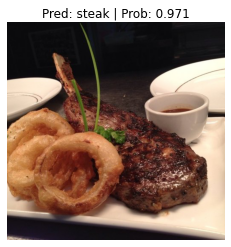

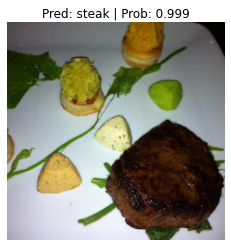

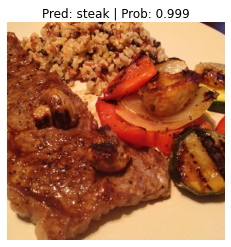

In [37]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

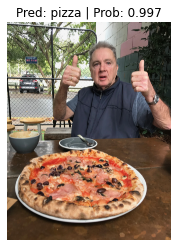

In [41]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    response = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(response.content)

else:
  print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names)